# New York City Bycicle Flow Prediction #

### Author: Angelo Antonio Manzatto ###

### Problem ###

Forecasting the input flow and output flow of bycicle traffic on areas of New York City during a timeframe in order to help on public safety.

![New York](images/inoutflow.png)

### Model ###

This problem makes use of a Spatial Temporal Network called ST-ResNet that uses Residual Units to concatenate the feature spaces.

![ST-ResNet](images/ST-ResNet.png)

------------------------------

### This work was based on the following article and the credits go to their authors ###

Title: Deep Spatio-Temporal Residual Networks for Citywide Crowd Flows Prediction
Authors: Zhang, Junbo and Zheng, Yu and Qi, Dekang
Book Title: Proceedings of the Thirty-First AAAI Conference on Artificial Intelligence (AAAI-17), 
Pages:1655-1661
Year:2017

------------------------------

The dataset can be download checking the information on the following link:
https://github.com/lucktroy/DeepST/tree/master/data/BikeNYC

In [1]:
##################################################################################
# Libraries
##################################################################################  
import os
import math 

from datetime import datetime
from datetime import timedelta  

import numpy as np

import h5py

import matplotlib.pyplot as plt
import matplotlib.cm 

import seaborn as sns
sns.set()

import keras.backend as K

from keras.models import Model

from keras.layers import Input, Dense, Reshape, Activation, Add
from keras.layers import Conv2D , BatchNormalization 

from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping

from keras.optimizers import Adam

from keras.engine.topology import Layer

Using TensorFlow backend.


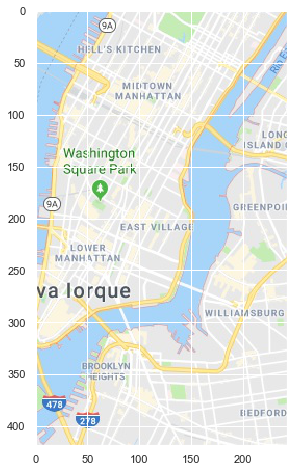

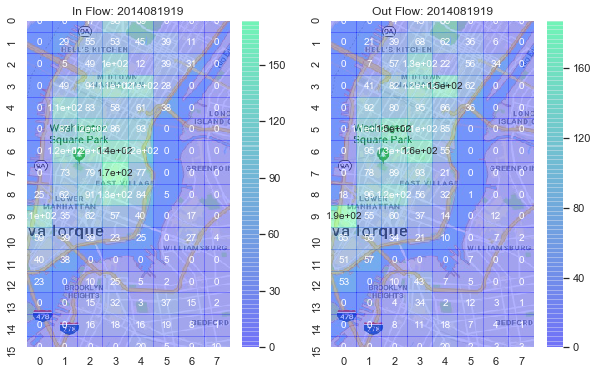

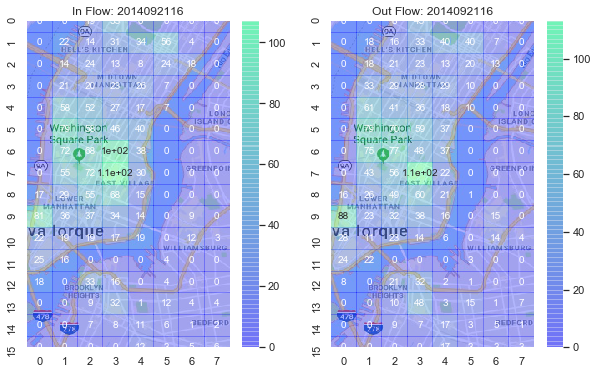

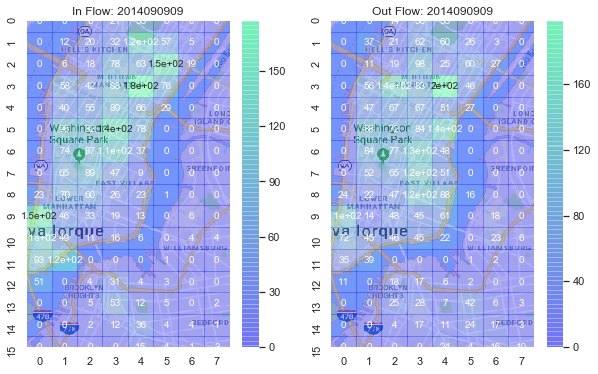

In [2]:
############################################################################################
# Load Dataset
############################################################################################
  
dataset_folder = 'dataset'
dataset_file = os.path.join(dataset_folder,'NYC14_M16x8_T60_NewEnd.h5')

images_folder = 'images'
nyc_map = plt.imread(os.path.join(images_folder,'nyc.jpg'))

# Plot New York Map
f, ax = plt.subplots(figsize=(8,8))
ax.imshow(nyc_map)

# Load dataset file
f = h5py.File(dataset_file)
data = f['data'][()]
timestamps = f['date'][()]
      
# Convert data from [batch x flow matrices x map height x map width] to [batch x map height x map width x flow matrices]
data = np.transpose(data, (0, 2, 3, 1))

# Plot some samples from dataset
n_samples = 3

for i in range(n_samples):
    
    # define the size of images
    f, (ax1, ax2) = plt.subplots(1, 2)
    f.set_figwidth(10)
    f.set_figheight(6)
    # randomly select a sample
    idx = np.random.randint(0, len(data))
    inflow = data[idx][:,:,0] #input flow is the first matrix
    outflow = data[idx][:,:,1] #output flow is the second matrix
    
    hmax1 = sns.heatmap(inflow, cmap = matplotlib.cm.winter, alpha = 0.3, annot = True,zorder = 2, ax=ax1)
    hmax1.imshow(nyc_map,aspect = hmax1.get_aspect(),extent = hmax1.get_xlim() + hmax1.get_ylim(), zorder = 1) 
    ax1.set_title('In Flow: {0}'.format(timestamps[idx].decode("utf-8")))
   
    hmax2 = sns.heatmap(outflow, cmap = matplotlib.cm.winter, alpha = 0.3, annot = True,zorder = 2, ax=ax2)
    hmax2.imshow(nyc_map,aspect = hmax2.get_aspect(),extent = hmax2.get_xlim() + hmax2.get_ylim(), zorder = 1) 
    ax2.set_title('Out Flow: {0}'.format(timestamps[idx].decode("utf-8")))

In [3]:
############################################################################################
# Pre-Process Dataset
############################################################################################
    
# Convert timestamps from ASCII format to string
formated_timestamps = []
for ts in timestamps:
    formated_timestamps.append(ts.decode("utf-8"))
    
# Scale in flow and out flow values on the map matrices to a range between [-1,1]    
min_value = data.min()
max_value = data.max()    

print("Minimum values: {0} , Maximum value: {1}".format(min_value,max_value))

data_scaled = 1. * (data - min_value) / (max_value - min_value)
data_scaled = 2. * data_scaled - 1.

print("Minimum scaled values: {0} , Maximum scaled value: {1}".format(data_scaled.min(),data_scaled.max()))

Minimum values: 0.0 , Maximum value: 267.0
Minimum scaled values: -1.0 , Maximum scaled value: 1.0


In [4]:
############################################################################################
# Create Train / Target data
############################################################################################
'''
Minimum granularity will be 1 hour

To create the input for our model we need to aggregate the inflow and outflow matrices according
to three interval of times defined in the article as: closeness, period and trend.

For this project:
 * Closeness is a difference in 1 hour period between two matrices
 * Period is a difference is 24 hours period between two matrices
 * Trend is a difference is 7 days period between two matrices
 
This means that for example, for a data (16 x 8 x 2) inflow/outflow matrices collected
at time stamp: 2014 08 07 01:00:00 we will have to do the following transformations:
    
Input closeness = len closeness stack of consecutive matrices distant between closeness interval.
Ex: Len = 3 and interval = 1 hour - stack [2014 08 07 01:00:00, 2014 08 07 02:00:00 , 2014 08 07 03:00:00]  matrices

Input period = len period stack of consecutive matrices distant between period interval.   
Ex: Len = 4 and interval = 24 hours - stack [2014 08 07 01:00:00, 2014 08 08 01:00:00 , 2014 08 09 01:00:00, 2014 08 10 01:00:00] matrices

Input trend = len trend stack of consecutive matrices distant between trend interval.   
Ex: Len = 4 and interval = 168 hours - stack [2014 08 07 01:00:00, 2014 08 14 01:00:00 , 2014 08 21 01:00:00, 2014 08 28 01:00:00] matrices    

This is an important information and the dataset should have little or almost NO disconnected interval between two
inflow / outflow matrices meaning that we should avoid missing hours.
'''

# Simple function that receives a string in format YmdH and convert to a datetime object
def str_to_date(timestamp):
    
    # We can't direct stripe the data using datetime.datetime.strptime(ts, '%Y%m%d%H')
    # because the hours are in 01 to 24 format instead of 00 to 23
    year, month, day, hour = int(timestamp[:4]), int(timestamp[4:6]), int(timestamp[6:8]), int(timestamp[8:])-1
    converted_time = datetime(year, month, day, hour)
    
    return converted_time

# Convert timestamp to a one hot encoded vector taking into account week way and if it is weekend or not
def one_hot_day_week(timestamp):
    
    converted_time = str_to_date(timestamp)
    i = converted_time.weekday()

    one_hot_encoded = np.zeros((8))
    
    # Day week (sunday, monday...) encoder
    one_hot_encoded[i] = 1
    
    # Weekend / Not Weekend encoder
    if i >= 5:
        one_hot_encoded[7] = 0
    else:
        one_hot_encoded[7] = 1
        
    return one_hot_encoded

closeness_interval = 1  # distance between hours
period_interval = 24 * closeness_interval  # number of time intervals in one day
trend_interval = 7 * period_interval

closeness_len = 3 # recent time (closeness) 
period_len = 4 # near history (period) 
trend_len = 4 # distant history (trend) 

closeness_range = [x * closeness_interval for x in range(1,closeness_len+1)]
period_range = [x * period_interval for x in range(1,period_len + 1)]
trend_range = [x * trend_interval  for x in range(1,trend_len+1)]

# Build a dictionary of time stamps. This will ease our work to convert between timestamps to indices to get
# the in/out flow matrices.
ts_dict = {}
ts_list = []
for i, ts in enumerate(formated_timestamps):
    
    converted_time = str_to_date(ts)
    
    # Add converted time from string to a list for iteration and for a dictionary for search purposes
    ts_list.append(str_to_date(ts))
    ts_dict[converted_time] = i

# Create X, y data    
X_Closeness, X_Period, X_Trend, X_external, Y , Y_timestamp = [],[],[],[],[],[]

# Crete the datasets for closeness, period and trend
# Since we have future predictions as output we need to build the dataset based on the lates trend period as starting point
starting_period = trend_interval * trend_len

# We construct the X, y datasets based on a reversed time interval, from the latest trend to starting closeness
for i in range(starting_period, len(formated_timestamps)):
    
    # Starting period
    date = str_to_date(formated_timestamps[i])
    
    check_dates = []
    
    # Get all dates in the closeness interval near the target 
    for c in closeness_range:
        check_dates.append(date - timedelta(hours=c))
        
    for p in period_range:
        check_dates.append(date - timedelta(hours=p))
        
    for t in trend_range:
        check_dates.append(date - timedelta(hours=t))
        
    # Check if all those selected dates exists in our timestamp dictionary and if not go to the next iteration
    for check_date in check_dates:
        if check_date not in ts_dict:
            print("Date frame missing!")
            continue
        
    # Parse again to create de dataset stacking the time range for closeness, period and trend
    
    # X Closeness
    xc = []
    for c in closeness_range:
        xc.append(data_scaled[ts_dict[date - timedelta(hours=c)]])
    xc = np.concatenate(xc,axis=-1)
    
    # X Period
    xp = []    
    for p in period_range:
        xp.append(data_scaled[ts_dict[date - timedelta(hours=p)]])
    xp = np.concatenate(xp,axis=-1)
    
    # X Trend
    xt = []    
    for t in trend_range:
        xt.append(data_scaled[ts_dict[date - timedelta(hours=t)]])
    xt = np.concatenate(xt,axis=-1) 
    
    # Target 
    y = data_scaled[ts_dict[date]]
    
    # Add each created set to the final datasets
    X_Closeness.append(xc)
    X_Period.append(xp)
    X_Trend.append(xt)
    X_external.append(one_hot_day_week(formated_timestamps[i]))
    
    Y.append(y)
    Y_timestamp.append(formated_timestamps[i])
    
X_Closeness = np.asarray(X_Closeness)
X_Period = np.asarray(X_Period)
X_Trend = np.asarray(X_Trend)
X_external = np.asarray(X_external)
Y = np.asarray(Y)

print("X_Closeness shape: ", X_Closeness.shape)
print("X_Period shape: ", X_Period.shape)
print("X_Trend shape: ", X_Trend.shape)
print("X_External shape: ", X_external.shape)
print( "Y shape:", Y.shape)

X_Closeness shape:  (3720, 16, 8, 6)
X_Period shape:  (3720, 16, 8, 8)
X_Trend shape:  (3720, 16, 8, 8)
X_External shape:  (3720, 8)
Y shape: (3720, 16, 8, 2)


In [5]:
############################################################################################
# Split dataset into Train / Test
############################################################################################

days_test = 10
n_test = 24 * days_test

# Split dataset into training / test sets
XC_train, XP_train, XT_train,XE_train, Y_train = X_Closeness[:-n_test], X_Period[:-n_test], X_Trend[:-n_test],X_external[:-n_test], Y[:-n_test]
XC_test, XP_test, XT_test, XE_test, Y_test = X_Closeness[-n_test:], X_Period[-n_test:], X_Trend[-n_test:],X_external[-n_test:], Y[-n_test:]
    
# Time stamp split so we can track the period
timestamp_train, timestamp_test = Y_timestamp[:-n_test], Y_timestamp[-n_test:]

# Concatenate closeness , period and trend 
X_train = [XC_train,XP_train,XT_train,XE_train]
X_test = [XC_test,XP_test,XT_test,XE_test]
    
print("X Train size: ", len(X_train))
print("X Test size: ", len(X_test))    

X Train size:  4
X Test size:  4


In [6]:
############################################################################################
# Spatial Temporal Residual Network - ST-ResNet
############################################################################################

############################################################################################
# Fusion Layer
############################################################################################
class FusionLayer(Layer):

    def __init__(self, **kwargs):
        super(FusionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        initial_weight_value = np.random.random(input_shape[1:])
        self.W = K.variable(initial_weight_value)
        self.trainable_weights = [self.W]

    def call(self, x, mask=None):
        return x * self.W
    
    def get_output_shape_for(self, input_shape):
        return input_shape

############################################################################################
# ResNet Identity Block
############################################################################################
def identity_block(inputs, filters, block_id):
    
    x = BatchNormalization(name='block_' + block_id + '_identity_batch_1')(inputs)
    x = Activation('relu', name='block_' + block_id + '_identity_relu_1')(x)
    x = Conv2D(filters, kernel_size=(3,3), strides=(1,1), padding='same', kernel_initializer='he_normal', name='block_' + block_id + '_identity_conv2d_1')(x)

    x = BatchNormalization(name='block_' + block_id + '_identity_batch_2')(x)
    x = Activation('relu',name='block_' + block_id + '_identity_relu_2')(x)
    x = Conv2D(filters, kernel_size=(3,3), strides=(1,1), padding='same', kernel_initializer='he_normal', name='block_' + block_id + '_identity_conv2d_2')(x)
    
    x = Add(name='block_' + block_id + '_add')([inputs,x])

    return x

############################################################################################
# Spatial Time Residual Network ST-ResNet
############################################################################################

map_height = 16
map_width = 8
n_flows = 2
    
c_conf=(map_height, map_width, n_flows, closeness_len) # closeness
p_conf=(map_height, map_width, n_flows, period_len) # period
t_conf=(map_height, map_width, n_flows, trend_len) # trend

# main input
main_inputs = []
outputs = []

for conf, name in zip([c_conf, p_conf, t_conf],['c','p','t']):
    
    map_height, map_width, n_flows, len_seq = conf
    
    Image = Input(shape=(map_height, map_width, n_flows * len_seq), name='input_' + name)
    
    main_inputs.append(Image)
    
    x = Conv2D(64, kernel_size=(3,3), padding="same")(Image)
    x = identity_block(x, 64, block_id='0_' + name)
    x = identity_block(x, 64, block_id='1_' + name)
    x = identity_block(x, 64, block_id='2_' + name)
    x = identity_block(x, 64, block_id='3_' + name)
    
    x = Activation('relu')(x)        
    x = Conv2D(n_flows, kernel_size=(3,3), padding="same")(x)
    
    output = FusionLayer(name="fusion_layer_" + name)(x)
    
    outputs.append(output)
        
# External component
external_dim = 8 # One Hot Encoded Timestamp into [weekday , weekend/notweekend]

# Concatenate external inputs with temporal inputs
external_input = Input(shape=(external_dim,), name='external_input')   
main_inputs.append(external_input)

embedding = Dense(10, name='external_dense_1')(external_input)
embedding = Activation('relu')(embedding)
embedding = Dense(n_flows * map_height * map_width)(embedding)
embedding = Activation('relu')(embedding)
external_output = Reshape((map_height, map_width, n_flows),name='external_output')(embedding)

# Fuse all layers
fusion_temporal =  Add(name= 'FusionTemporal')(outputs)

fusion = Add(name='Fusion')([fusion_temporal,external_output])

final_output = Activation('tanh', name='Tanh')(fusion) 

model = Model(inputs=main_inputs,outputs=final_output)

In [8]:
############################################################################################
# Training pipeline
############################################################################################

# Metric for our model
def rmse(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true)) ** 0.5

# Hyperparameters
epochs = 100
batch_size = 32
learning_rate = 0.0002
weight_decay = 5e-4
momentum = .9

# callbacks
model_path = 'saved_models'

# File were the best model will be saved during checkpoint     
model_file = os.path.join(model_path,'nyc_bike_flow-{val_loss:.4f}.h5')

# Early stop to avoid overfitting our model
early_stopping = EarlyStopping(monitor='val_rmse', patience=5, mode='min')

# Check point for saving the best model
check_pointer = ModelCheckpoint(model_file, monitor='val_rmse', mode='min',verbose=1, save_best_only=True)

# Logger to store loss on a csv file
csv_logger = CSVLogger(filename='nyc_bike_flow.csv',separator=',', append=True)

# Create Optimizer
optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

# Compile model for training
model.compile(optimizer, loss='mse' , metrics=[rmse])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_c (InputLayer)            (None, 16, 8, 6)     0                                            
__________________________________________________________________________________________________
input_p (InputLayer)            (None, 16, 8, 8)     0                                            
__________________________________________________________________________________________________
input_t (InputLayer)            (None, 16, 8, 8)     0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 8, 64)    3520        input_c[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (

In [ ]:
# Train the model
history = model.fit(X_train, Y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.1,
                    callbacks=[early_stopping, check_pointer, csv_logger],
                    verbose=1)

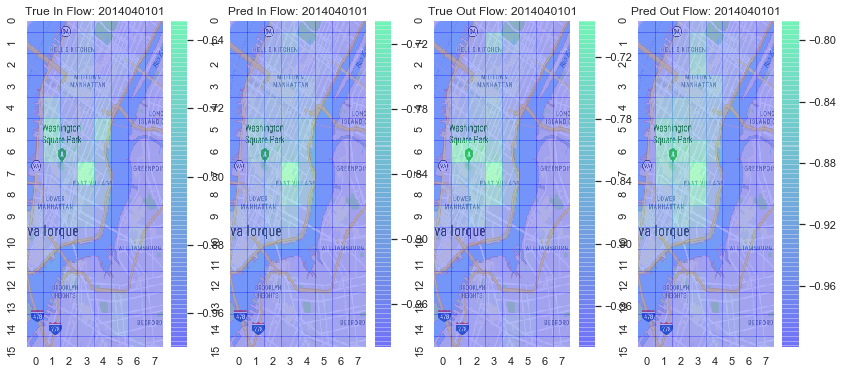

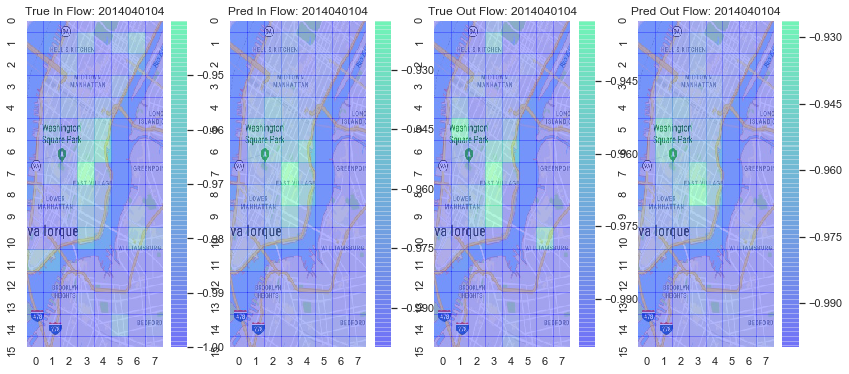

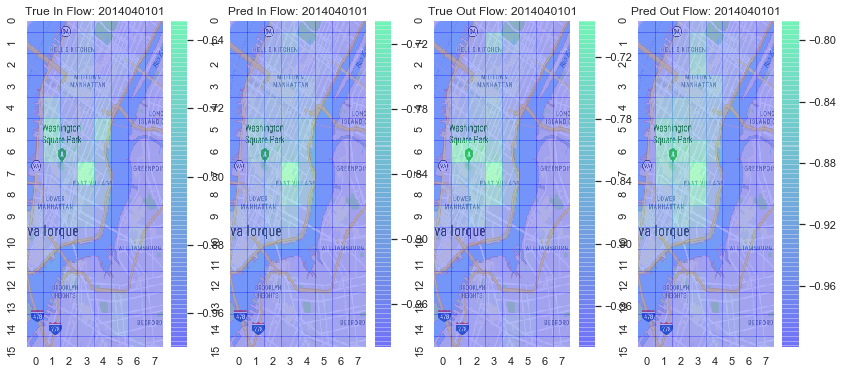

In [9]:
############################################################################################
# Predict
############################################################################################
# If we want to test on a pre trained model use the following line
model.load_weights(os.path.join(model_path,'bikenyc-0.0016.h5'), by_name=False)

n_samples = 3

for i in range(n_samples):
    
    f, (ax1, ax2, ax3,ax4) = plt.subplots(1, 4)
    f.set_figwidth(14)
    f.set_figheight(6)
    
    # randomly select a sample
    idx = np.random.randint(0, len(X_test))
    
    # Add single dimension to each input to simulate batch
    X = [X_test[0][idx][np.newaxis,...],X_test[1][idx][np.newaxis,...],X_test[2][idx][np.newaxis,...],X_test[3][idx][np.newaxis,...]]
    y_true = Y_test[idx]
    
    # Predict values using our trained model
    y_pred = model.predict(X)
    y_pred = np.squeeze(y_pred)
    
    hmax1 = sns.heatmap(y_true[:,:,0], cmap = matplotlib.cm.winter, alpha = 0.3, annot = False,zorder = 2, ax=ax1)
    hmax1.imshow(nyc_map,aspect = hmax1.get_aspect(),extent = hmax1.get_xlim() + hmax1.get_ylim(), zorder = 1) 
    ax1.set_title('True In Flow: {0}'.format(timestamps[idx].decode("utf-8")))
    
    hmax2 = sns.heatmap(y_pred[:,:,0], cmap = matplotlib.cm.winter, alpha = 0.3, annot = False,zorder = 2, ax=ax2)
    hmax2.imshow(nyc_map,aspect = hmax2.get_aspect(),extent = hmax2.get_xlim() + hmax2.get_ylim(), zorder = 1) 
    ax2.set_title('Pred In Flow: {0}'.format(timestamps[idx].decode("utf-8")))
    
    hmax3 = sns.heatmap(y_true[:,:,1], cmap = matplotlib.cm.winter, alpha = 0.3, annot = False,zorder = 2, ax=ax3)
    hmax3.imshow(nyc_map,aspect = hmax3.get_aspect(),extent = hmax3.get_xlim() + hmax3.get_ylim(), zorder = 1) 
    ax3.set_title('True Out Flow: {0}'.format(timestamps[idx].decode("utf-8")))
    
    hmax4 = sns.heatmap(y_pred[:,:,1], cmap = matplotlib.cm.winter, alpha = 0.3, annot = False,zorder = 2, ax=ax4)
    hmax4.imshow(nyc_map,aspect = hmax4.get_aspect(),extent = hmax4.get_xlim() + hmax4.get_ylim(), zorder = 1) 
    ax4.set_title('Pred Out Flow: {0}'.format(timestamps[idx].decode("utf-8")))

In [10]:
############################################################################################
# Evaluate
############################################################################################   

# This information was provided in the original article an file !
'''    
For NYC Bike data, there are 81 available grid-based areas, each of
which includes at least ONE bike station. Therefore, we modify the final
RMSE by multiplying the following factor (i.e., factor).
'''
nb_area = 81
m_factor = math.sqrt(1. * map_height * map_width / nb_area)

score = model.evaluate(X_train, Y_train, batch_size=Y_train.shape[0] // 48, verbose=0)
print('Train score: %.6f rmse (norm): %.6f rmse (real): %.6f' %
      (score[0], score[1], score[1] * (max_value - min_value) / 2. * m_factor))

score = model.evaluate(X_test, Y_test, batch_size=Y_test.shape[0], verbose=0)
print('Test score: %.6f rmse (norm): %.6f rmse (real): %.6f' %
      (score[0], score[1], score[1] * (max_value - min_value) / 2. * m_factor))


Train score: 0.001074 rmse (norm): 0.032450 rmse (real): 5.445725
Test score: 0.001862 rmse (norm): 0.043154 rmse (real): 7.242186
